# Fetching MNIST Dataset

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [2]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [3]:
X, y = mnist.data, mnist.target

In [4]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

Plotting the first training instance

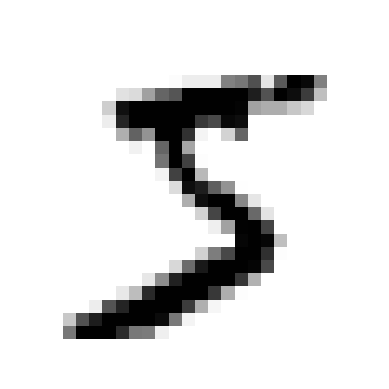

In [7]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [8]:
X_train, X_val, X_test, y_train, y_val, y_test = X[:50000], X[50000:60000], X[60000:], y[:50000], y[50000:60000], y[60000:]

Training with GridSearchCV to determine hyperparameters. On a first iteration hyperparameters weights='distance' and 'n_neighbors' = 3 got the best score. Now training a second iteration to narrow down on the best 'n_neighbors' value (since on first iteration only values 1,3,5 and 7 were tested).

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'n_neighbors':[2, 3, 4, 5]}
neigh = KNeighborsClassifier(weights='distance')
clf = GridSearchCV(neigh, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(weights='distance'),
             param_grid={'n_neighbors': [2, 3, 4, 5]})

In [11]:
clf.best_params_

{'n_neighbors': 4}

In [12]:
import pandas as pd
cv_res = pd.DataFrame(clf.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.127310,0.000247,4.128424,0.028766,4,{'n_neighbors': 4},0.9694,0.9715,0.9701,0.9690,0.9670,0.96940,0.001471,1
1,0.129080,0.002250,4.157275,0.031928,3,{'n_neighbors': 3},0.9687,0.9702,0.9691,0.9693,0.9653,0.96852,0.001683,2
3,0.129044,0.001107,4.148109,0.027432,5,{'n_neighbors': 5},0.9673,0.9709,0.9692,0.9689,0.9651,0.96828,0.001958,3
0,0.130983,0.004377,4.392079,0.401053,2,{'n_neighbors': 2},0.9682,0.9696,0.9672,0.9673,0.9640,0.96726,0.001843,4


### Accuracy score on test set.

In [13]:
clf.best_estimator_.score(X_val, y_val)

0.9741

## Data augmentation

We will thrive to improve accuracy by augmenting the training data. We will be performing pixel shifts and rotations on the training images to extend our training set and improve the generalization of the model on new unseen instances.

In [9]:
from scipy.ndimage import shift, rotate
import numpy as np

X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

#def rotate_image(image, rot_angle):
#    image = image.reshape((28, 28))
#    shifted_image = rotate(image, rot_angle, reshape="False")
#    return shifted_image.reshape([-1])

for dx, dy in ((1,0), (-1,0), (0,1), (0,-1)):
     for image, label in zip(X_train, y_train):
             X_train_augmented.append(shift_image(image, dx, dy))
             y_train_augmented.append(label)
            
#for angle in (90, 180, 270):
#     for image, label in zip(X_train, y_train):
#             X_train_augmented.append(rotate_image(image, angle))
#             y_train_augmented.append(label)

            

In [10]:
np.asarray(X_train_augmented).shape

(250000, 784)

Shuffling augmented training set

In [11]:
from sklearn.utils import shuffle
X_train_augmented, y_train_augmented = shuffle(X_train_augmented, y_train_augmented, random_state=0)

In [17]:
from sklearn.neighbors import KNeighborsClassifier

neigh_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
neigh_clf.fit(X_train_augmented, y_train_augmented)
neigh_clf.score(X_val,y_val)

0.9795

Accuracy increased by 0.5% by augmenting the data.

# Training and fine-tuning different models to build an ensemble

### Random Forest classifier

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define the hyperparameter space
n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 3000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 20, num = 11)]
max_depth.append(None)
min_samples_split = [10, 15, 20, 25, 30]
min_samples_leaf = [1, 2, 3, 4, 5]
bootstrap = [True, False]

random_grid = {
    'random_forest__n_estimators': n_estimators,
    'random_forest__max_features': max_features,
    'random_forest__max_depth': max_depth,
    'random_forest__min_samples_split': min_samples_split,
    'random_forest__min_samples_leaf': min_samples_leaf,
    'random_forest__bootstrap': bootstrap
}


# Instantiate the random forest classifier
full_pipeline_forest = Pipeline([
    ("scaler", StandardScaler()),
    ("random_forest", RandomForestClassifier(random_state=42)),
])

rf_random = RandomizedSearchCV(
    full_pipeline_forest, param_distributions=random_grid, n_iter=50, cv=5,
    scoring='accuracy', random_state=42, n_jobs=-1, verbose=0)

# Fit the model to the training data
rf_random.fit(X_train_augmented[:5000], y_train_augmented[:5000])

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('random_forest',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'random_forest__bootstrap': [True,
                                                                     False],
                                        'random_forest__max_depth': [5, 6, 8, 9,
                                                                     11, 12, 14,
                                                                     15, 17, 18,
                                                                     20, None],
                                        'random_forest__max_features': ['log2',
                                                                        'sqrt'],
                                        'random_forest__min_samples_leaf': [1,
                                                                            2,
                                                                            3,
                                                                            4,
                                                                            5],
                                        'random_forest__min_samples_split': [10,
                                                                             15,
                                                                             20,
                                                                             25,
                                                                             30],
                                        'random_forest__n_estimators': [1000,
                                                                        1222,
                                                                        1444,
                                                                        1666,
                                                                        1888,
                                                                        2111,
                                                                        2333,
                                                                        2555,
                                                                        2777,
                                                                        3000]},
                   random_state=42, scoring='accuracy')

In [22]:
# Print the best hyperparameters found
print(rf_random.best_params_)

{'random_forest__n_estimators': 1666, 'random_forest__min_samples_split': 15, 'random_forest__min_samples_leaf': 3, 'random_forest__max_features': 'sqrt', 'random_forest__max_depth': 20, 'random_forest__bootstrap': False}


In [23]:
rf_random.best_estimator_.score(X_val, y_val)

0.9419

### Extra-Trees classifier

In [24]:
from sklearn.ensemble import ExtraTreesClassifier

# Define the hyperparameter space
n_estimators = [int(x) for x in np.linspace(start = 2000, stop = 4000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 20, num = 11)]
max_depth.append(None)
min_samples_split = [10, 15, 20, 25, 30]
min_samples_leaf = [1, 2, 3, 4, 5]
bootstrap = [True, False]

random_grid = {
    'extra_trees__n_estimators': n_estimators,
    'extra_trees__max_features': max_features,
    'extra_trees__max_depth': max_depth,
    'extra_trees__min_samples_split': min_samples_split,
    'extra_trees__min_samples_leaf': min_samples_leaf,
    'extra_trees__bootstrap': bootstrap
}


# Instantiate the random forest classifier
full_pipeline_extratrees = Pipeline([
    ("scaler", StandardScaler()),
    ("extra_trees", ExtraTreesClassifier(random_state=42)),
])

et_random = RandomizedSearchCV(
    full_pipeline_extratrees, param_distributions=random_grid, n_iter=50, cv=5,
    scoring='accuracy', random_state=42, n_jobs=-1, verbose=0)

# Fit the model to the training data
et_random.fit(X_train_augmented[:5000], y_train_augmented[:5000])

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('extra_trees',
                                              ExtraTreesClassifier(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'extra_trees__bootstrap': [True, False],
                                        'extra_trees__max_depth': [5, 6, 8, 9,
                                                                   11, 12, 14,
                                                                   15, 17, 18,
                                                                   20, None],
                                        'extra_trees__max_features': ['log2',
                                                                      'sqrt'],
                                        'extra_trees__min_samples_leaf': [1, 2,
                                                                          3, 4,
                                                                          5],
                                        'extra_trees__min_samples_split': [10,
                                                                           15,
                                                                           20,
                                                                           25,
                                                                           30],
                                        'extra_trees__n_estimators': [2000,
                                                                      2222,
                                                                      2444,
                                                                      2666,
                                                                      2888,
                                                                      3111,
                                                                      3333,
                                                                      3555,
                                                                      3777,
                                                                      4000]},
                   random_state=42, scoring='accuracy')

In [25]:
# Print the best hyperparameters found
print(et_random.best_params_)

{'extra_trees__n_estimators': 2888, 'extra_trees__min_samples_split': 20, 'extra_trees__min_samples_leaf': 1, 'extra_trees__max_features': 'sqrt', 'extra_trees__max_depth': 14, 'extra_trees__bootstrap': False}


In [26]:
et_random.best_estimator_.score(X_val, y_val)

0.9373

### SVM Classifier

In [28]:
from sklearn.svm import SVC

# Define the hyperparameter space
C = [int(x) for x in np.linspace(start = 1, stop = 1000, num = 10)]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto']

random_grid = {
    'svc__C': C,
    'svc__kernel': kernel,
    'svc__gamma': gamma
}


# Instantiate the random forest classifier
full_pipeline_svc = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=42)),
])

svc_random = RandomizedSearchCV(
    full_pipeline_svc, param_distributions=random_grid, n_iter=50, cv=5,
    scoring='accuracy', random_state=42, n_jobs=-1, verbose=0)

# Fit the model to the training data
svc_random.fit(X_train_augmented[:5000], y_train_augmented[:5000])

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svc', SVC(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'svc__C': [1, 112, 223, 334, 445, 556,
                                                   667, 778, 889, 1000],
                                        'svc__gamma': ['scale', 'auto'],
                                        'svc__kernel': ['linear', 'poly', 'rbf',
                                                        'sigmoid']},
                   random_state=42, scoring='accuracy')

In [29]:
# Print the best hyperparameters found
print(svc_random.best_params_)

{'svc__kernel': 'poly', 'svc__gamma': 'scale', 'svc__C': 667}


In [30]:
svc_random.best_estimator_.score(X_val, y_val)

0.9423

# Ensemble learning

### Voting Classifier

In [14]:
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


# Instantiate multiple classifiers with previously optimized hyperparameters and preprocessing pipeline
pipe_rf = Pipeline([
    #("scaler", StandardScaler()),
    ("random_forest", RandomForestClassifier(random_state=42, n_estimators = 1666, 
                                        min_samples_split = 15, bootstrap = False,
                                        min_samples_leaf = 3, max_features = 'sqrt', max_depth = 20)),
])

pipe_et = Pipeline([
    #("scaler", StandardScaler()),
    ("extra_trees", ExtraTreesClassifier(random_state=42, n_estimators = 2888, 
                                        min_samples_split = 20, bootstrap = False,
                                        min_samples_leaf = 1, max_features = 'sqrt', max_depth = 14)),
])

pipe_svc = Pipeline([
    #("scaler", StandardScaler()),
    ("svc_clf", SVC(random_state=42, kernel='poly', gamma = 'scale', C = 667, probability=True)),
])

pipe_kneigh = Pipeline([
    #("scaler", StandardScaler()),
    ("kneigh_clf", KNeighborsClassifier(weights = 'distance', n_neighbors = 4)),
])

# Define a voting classifier that combines the predictions of the four models
voting = VotingClassifier(
    estimators=[
                ('rf', pipe_rf),
                ('et', pipe_et),
                ('svc', pipe_svc)
                #('kneigh', pipe_kneigh)
    ], 
    voting='hard'
)

# Fit the voting classifier to the training data
voting.fit(X_train_augmented, y_train_augmented)

# Evaluate the performance on the training set
accuracy = voting.score(X_train_augmented, y_train_augmented)
print("Accuracy score of the ensemble model: {:.3f}".format(accuracy))

Accuracy score of the ensemble model: 0.996


In [15]:
# Evaluate the performance on the validation set
accuracy = voting.score(X_val, y_val)
print("Accuracy score of the ensemble model on validation set: {:.3f}".format(accuracy))

Accuracy score of the ensemble model on validation set: 0.979


In [16]:
# Evaluate the performance on the test set
accuracy = voting.score(X_val, y_val)
print("Accuracy score of the ensemble model on the test set: {:.3f}".format(accuracy))

Accuracy score of the ensemble model on the test set: 0.979


### Stacking classifier 

We will build a stacking classifier both manually and with Sklearn's library. We'll start manually:

In [23]:
X_train_layer11 = voting.named_estimators_["rf"].predict(X_val)
X_train_layer12 = voting.named_estimators_["et"].predict(X_val)
X_train_layer13 = voting.named_estimators_["svc"].predict(X_val)

In [44]:
X_train_layer1 = np.column_stack((X_train_layer11, X_train_layer12, X_train_layer13))

In [45]:
X_train_layer1.shape

(10000, 3)

In [46]:
final_estimator = RandomForestClassifier(random_state=42)

final_estimator.fit(X_train_layer1, y_val)

RandomForestClassifier(random_state=42)

In [47]:
X_test_layer11 = voting.named_estimators_["rf"].predict(X_test)
X_test_layer12 = voting.named_estimators_["et"].predict(X_test)
X_test_layer13 = voting.named_estimators_["svc"].predict(X_test)

In [48]:
X_test_layer1 = np.column_stack((X_test_layer11, X_test_layer12, X_test_layer13))

In [49]:
# Evaluate the performance on the test set
accuracy = final_estimator.score(X_test_layer1, y_test)
print("Accuracy score of the stacking classifier on the test set: {:.3f}".format(accuracy))

Accuracy score of the stacking classifier on the test set: 0.983


Now we will use Sklearn's StackingClassifier:

In [50]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
                estimators=[
                    ('rf', voting.named_estimators_["rf"]),
                    ('et', voting.named_estimators_["et"]),
                    ('svc', voting.named_estimators_["svc"])
                ],
                final_estimator=RandomForestClassifier(random_state=42),
                cv=5
)
stacking_clf.fit(X_val, y_val)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                Pipeline(steps=[('random_forest',
                                                 RandomForestClassifier(bootstrap=False,
                                                                        max_depth=20,
                                                                        min_samples_leaf=3,
                                                                        min_samples_split=15,
                                                                        n_estimators=1666,
                                                                        random_state=42))])),
                               ('et',
                                Pipeline(steps=[('extra_trees',
                                                 ExtraTreesClassifier(max_depth=14,
                                                                      min_samples_split=20,
                                                                      n_estimators=2888,
                                                                      random_state=42))])),
                               ('svc',
                                Pipeline(steps=[('svc_clf',
                                                 SVC(C=667, kernel='poly',
                                                     probability=True,
                                                     random_state=42))]))],
                   final_estimator=RandomForestClassifier(random_state=42))

In [51]:
# Evaluate the performance on the test set
accuracy = stacking_clf.score(X_test, y_test)
print("Accuracy score of Sklearn's stacking classifier on the test set: {:.3f}".format(accuracy))

Accuracy score of Sklearn's stacking classifier on the test set: 0.964
